<a href="https://colab.research.google.com/github/EstSov/PP/blob/main/CUDA_6_7_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /usr/local/
!rm -rf cuda
!ln -s /usr/local/cuda-10.1 /usr/local/cuda
!stat cuda
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

/usr/local
  File: cuda -> /usr/local/cuda-10.1
  Size: 20        	Blocks: 0          IO Block: 4096   symbolic link
Device: 24h/36d	Inode: 4849667     Links: 1
Access: (0777/lrwxrwxrwx)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2022-05-20 08:29:56.601124853 +0000
Modify: 2022-05-20 08:29:56.498114985 +0000
Change: 2022-05-20 08:29:56.498114985 +0000
 Birth: -
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-u7edbbd_
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-u7edbbd_
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4306 sha256=9f97626316803f01caf31f4b1f08df0997949fc32ae5aa41904d7328df1896ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-w2hr61p0/wheels/ca/33/8d/3c86eb85e97d2b6169d95c6e8f2c297fdec60db6e84cb56f5e
Successfully built NVCCPlugin
directory /usr/local/src already exists
Out bin /usr/local/result.out


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
%%cu
#include <iostream>
int main() {
    std::cout << "Hello world\n";
    return 0;
}

Hello world



С помощью технологии CUDA реализовать параллельный вариант перемножения матриц.
Сравнить время выполнения алгоритма (N=100, 1k, 2k):
1. Ваш вариант на GPU.
2. Обычное перемножение матриц на CPU (плюс сравнить результаты численно).

In [4]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>

#include <iostream>
#include <ctime>


void Error(cudaError_t err) {
	if (err != cudaSuccess) {
		printf("%s\n", cudaGetErrorString(err));
		exit(-1);
	}
}

__global__ void kernel(int *a, int *b, int *c, int count) {
	int i = threadIdx.y + blockIdx.y * blockDim.y;
	int j = threadIdx.x + blockIdx.x * blockDim.x;
	c[i * count + j] = 0;
	for (int k = 0; k < count; k++) {
		c[i * count + j] += a[i * count + k] * b[k * count + j];
	}
}

int main() {

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

	srand(time(0));
	int N = 2000;
	int size = 2;
	dim3 block(N / size, N / size);
	dim3 threads(size, size);
	int *dev_c, *dev_a, *dev_b;
	int *a, *b, *c, *c1;
	a = new int[N * N];
	b = new int[N * N];
	c = new int[N * N];
  c1 = new int[N * N];
	for (int i = 0; i < N; i++) {
		for (int j = 0; j < N; j++) {
			a[i*N + j] = rand() % 10;
			b[i*N + j] = rand() % 10;
		}
	}



/*	std::cout << "A" << std::endl;
	for (int i = 0; i < N; i++) {
		for (int j = 0; j < N; j++) {
			std::cout << a[i*N + j] << "  ";
		}
		std::cout << std::endl;
	}
	std::cout << "B" << std::endl;
	for (int i = 0; i < N; i++) {
		for (int j = 0; j < N; j++) {
			std::cout << b[i*N + j] << "  ";
		}
		std::cout << std::endl;
	}*/

 cudaEventRecord(start);

	//int time = GetTickCount();
	Error(cudaMalloc((void **)&dev_c, sizeof(int) * N * N));
	Error(cudaMalloc((void **)&dev_b, sizeof(int) * N * N));
	Error(cudaMalloc((void **)&dev_a, sizeof(int) * N * N));
	Error(cudaMemcpy(dev_a, a, sizeof(int) * N * N, cudaMemcpyHostToDevice));
	Error(cudaMemcpy(dev_b, b, sizeof(int) * N * N, cudaMemcpyHostToDevice));
	kernel << <block, threads >> > (dev_a, dev_b, dev_c, N);
	Error(cudaGetLastError());
	Error(cudaDeviceSynchronize());
	Error(cudaMemcpy(c, dev_c, sizeof(int) * N * N, cudaMemcpyDeviceToHost));
	//std::cout << "Time: " << GetTickCount() - time << std::endl;

    cudaEventRecord(stop);
  cudaEventSynchronize(stop);
  cudaDeviceSynchronize();

 float milliseconds = 0;
  cudaEventElapsedTime(&milliseconds, start, stop);
std::cout <<"time: %f (s)\n" << milliseconds/1000;


/*std::cout << "C" << std::endl;
	for (int i = 0; i < N; i++) {
		for (int j = 0; j < N; j++) {
			std::cout << c[i*N + j] << "  ";
		}
		std::cout << std::endl;
  }*/



	Error(cudaFree(dev_c));
	Error(cudaFree(dev_b));
	Error(cudaFree(dev_a));

	
	return 0;


}

time: %f (s)
1.10738


N = 100
time = 0.00108493 
N = 1000
time = 0.672228 
N = 2000
time = 4.61971

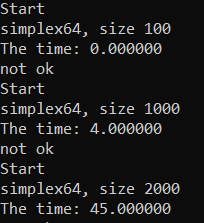

С помощью технологии CUDA реализовать параллельный вариант перемножения матриц.
Использовать shared-память.
Сравнить время выполнения алгоритма (N=100, 1k, 2k):
1. Ваш предыдущий вариант на GPU (без shared-памяти).
2. Ваш текущий вариант на GPU (с shared-памятью).
2. На CPU (плюс сравнить результаты численно).

In [5]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>

#include <iostream>
#include <ctime>

const int SIZE_OF_BLOCK = 16;

void Error(cudaError_t err) {
	if (err != cudaSuccess) {
		printf("%s\n", cudaGetErrorString(err));
		exit(-1);
	}
}

__global__ void kernel() {
}

__global__ void matMult(int *A, int *B, int *C, int N) {
	int A_begin = N * SIZE_OF_BLOCK;
	A_begin = A_begin * blockIdx.y;
	int A_end = A_begin + N - 1;
	int B_begin = SIZE_OF_BLOCK;
	B_begin = B_begin * blockIdx.x;
	int A_step = SIZE_OF_BLOCK;
	int B_step = SIZE_OF_BLOCK * N;
	int sum = 0;

	__shared__ int A_shared[SIZE_OF_BLOCK][SIZE_OF_BLOCK];
	__shared__ int B_shared[SIZE_OF_BLOCK][SIZE_OF_BLOCK];
	for (int i_A = A_begin, i_B = B_begin; i_A <= A_end; i_A += A_step, i_B += B_step) {
		A_shared[threadIdx.y][threadIdx.x] = A[i_A + N * threadIdx.y + threadIdx.x];
		B_shared[threadIdx.y][threadIdx.x] = B[i_B + N * threadIdx.y + threadIdx.x];
		__syncthreads();
		for (int k = 0; k < SIZE_OF_BLOCK; k++) {
			sum += A_shared[threadIdx.y][k] * B_shared[k][threadIdx.x];
		}
		__syncthreads();
		C[N * SIZE_OF_BLOCK * blockIdx.y + SIZE_OF_BLOCK * blockIdx.x + N * threadIdx.y + threadIdx.x] = sum;
	}
}
int main() {
	srand(time(0));
	int N = 2000;

   cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);
	std::cout << "Size " << N << std::endl;
	dim3 block(N / SIZE_OF_BLOCK, N / SIZE_OF_BLOCK);
	dim3 threads(SIZE_OF_BLOCK, SIZE_OF_BLOCK);
	int *dev_c, *dev_a, *dev_b;
	int *a, *b, *c;
	a = new int[N * N];
	b = new int[N * N];
	c = new int[N * N];
	for (int i = 0; i < N; i++) {
		for (int j = 0; j < N; j++) {
			a[i*N + j] = rand() % 10;
			b[i*N + j] = rand() % 10;
		}
	}

	
  cudaEventRecord(start);
	Error(cudaMalloc((void **)&dev_c, sizeof(int) * N * N));
	Error(cudaMalloc((void **)&dev_b, sizeof(int) * N * N));
	Error(cudaMalloc((void **)&dev_a, sizeof(int) * N * N));
	Error(cudaMemcpy(dev_a, a, sizeof(int) * N * N, cudaMemcpyHostToDevice));
	Error(cudaMemcpy(dev_b, b, sizeof(int) * N * N, cudaMemcpyHostToDevice));
	
	matMult << <block, threads >> > (dev_a, dev_b, dev_c, N);
	Error(cudaGetLastError());
	Error(cudaMemcpy(c, dev_c, sizeof(int) * N * N, cudaMemcpyDeviceToHost));

    cudaEventRecord(stop);
  cudaEventSynchronize(stop);
  cudaDeviceSynchronize();

 float milliseconds = 0;
  cudaEventElapsedTime(&milliseconds, start, stop);
std::cout <<"time: %f (s)\n" << milliseconds/1000;

	Error(cudaFree(dev_c));
	Error(cudaFree(dev_b));
	Error(cudaFree(dev_a));


	return 0;

}

Size 2000
time: %f (s)
0.0599855


N = 100 time = 0.0002 N = 1000 time = 0.00872675 N = 2000 time = 0.0596952

С помощью технологии CUDA реализовать параллельный вариант алгоритма Флойда.
Сравнить время выполнения алгоритма (N=100, 1k, 2k):
1. Ваш вариант на GPU.
2. На CPU (плюс сравнить результаты численно).

In [9]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>

#include <iostream>
#include <ctime>
#include <algorithm>
#include <iomanip>

void Error(cudaError_t err) {
	if (err != cudaSuccess) {
		printf("%s\n", cudaGetErrorString(err));
		exit(-1);
	}
}

__global__ void kernel(int *G, int count, int k) {
	int i = threadIdx.y + blockIdx.y * blockDim.y;
	int j = threadIdx.x + blockIdx.x * blockDim.x;
	G[i * count + j] = min(G[i * count + j], G[i * count + k] + G[k * count + j]);
}
__global__ void kernel() {
}
int main() {
 cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);
	int N = 2000;
	srand(time(0));
	int size = 20;
	dim3 block(N / size, N / size);
	dim3 threads(size, size);
	int *dev_G;
	int *G;
	G = new int[N * N];
	for (size_t i = 0; i < N; i++) {
		for (size_t j = 0; j < N; j++) {
			if (i != j) {
				G[i*N + j] = rand() % 100;
			}
			else
				G[i*N + j] = 0;
		}
	}

	kernel << <block, threads >> > ();
	Error(cudaGetLastError());
	Error(cudaDeviceSynchronize());
	
	Error(cudaMalloc((void **)&dev_G, sizeof(int) * N * N));
	Error(cudaMemcpy(dev_G, G, sizeof(int) * N * N, cudaMemcpyHostToDevice));
	cudaEventRecord(start);
	for (int i = 0; i < N; i++) {
		kernel << <block, threads >> > (dev_G, N, i);
		Error(cudaGetLastError());
		Error(cudaDeviceSynchronize());
	}
	Error(cudaMemcpy(G, dev_G, sizeof(int) * N * N, cudaMemcpyDeviceToHost));
	    cudaEventRecord(stop);
  cudaEventSynchronize(stop);
  cudaDeviceSynchronize();

 float milliseconds = 0;
  cudaEventElapsedTime(&milliseconds, start, stop);
std::cout <<"time: %f (s)\n" << milliseconds/1000;

	Error(cudaFree(dev_G));

	system("pause");
	return 0;

}

sh: 1: pause: not found
time: %f (s)
0.380389


N = 100 time = 0.00104922 N = 1000 time = 0.0509755 N = 2000 time = 0.380389